In [1]:
import operator

from langchain_core.messages import HumanMessage, ToolMessage, RemoveMessage

from config import EXA_API_KEY
from config import set_environment
from IPython.core.display import Image
from langgraph.constants import END, START
from langgraph.graph import  StateGraph
from pydantic import BaseModel
from langchain_mistralai import ChatMistralAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import  SystemMessage
from typing import Annotated, Optional
from langchain_community.document_loaders import WikipediaLoader
from pydantic import Field
from langgraph.types import Send
from langchain_exa import ExaSearchRetriever

In [2]:
set_environment()

In [3]:
import os
key = os.getenv("MISTRAL_API_KEY")
print(f"Key exists: {key is not None}")

Key exists: True


In [4]:
llm = ChatMistralAI(model = "mistral-small-latest")

In [6]:
create_analyst_prompt = ("You are given the task of creating AI analysts with different personas. Here are the instructions. Follow them carefully."
"1. You are given a research topic. Topic: {topic}."
"2. You are also given human feedback for analysts you created. Incorporate the feedback and further refine the analysts. Human Feedback: {human_feedback}"
"3. Decide on the most interesting themes based on the topic and the human feedback."
"4. Pick the top {max_analysts} themes."
"5. Assign one analyst to each of the theme based on their role and organization.")

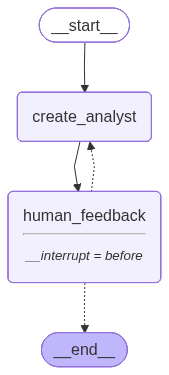

In [7]:
class Analyst(BaseModel):
    name:str = Field(description='Name of analyst')
    organization:str = Field(description='Organization of then analyst')
    role:str = Field(description='Role of the analyst')
    description:str = Field(description='Description of the analyst')
    
class Analysts(BaseModel):
    analysts: list[Analyst] = Field(default_factory=list, description="Comprehensive list of analysts with their name, role, organization and description")

class CreateAnalystState(BaseModel):
    max_analysts: int = 0
    topic: str
    human_feedback: Optional[str] = None
    analysts: list[Analyst] = None
    
def create_analyst(state: CreateAnalystState):
    prmpt = create_analyst_prompt.format(topic=state.topic, human_feedback=state.human_feedback, max_analysts=state.max_analysts)
    results = llm.with_structured_output(Analysts).invoke(prmpt)
    return {"analysts": results.analysts}

def human_feedback(state: CreateAnalystState):
    pass

def check_for_feedback(state: CreateAnalystState):
    if state.human_feedback is not None and state.human_feedback != "":
        return "create_analyst"
    else:
        return END

create_analyst_builder = StateGraph(CreateAnalystState)
create_analyst_builder = create_analyst_builder.add_node("create_analyst", create_analyst)
create_analyst_builder = create_analyst_builder.add_node("human_feedback", human_feedback)

create_analyst_builder = create_analyst_builder.add_edge(START, "create_analyst")
create_analyst_builder = create_analyst_builder.add_edge("create_analyst", "human_feedback")
create_analyst_builder = create_analyst_builder.add_conditional_edges("human_feedback", check_for_feedback, ["create_analyst", END])
create_analyst_builder = create_analyst_builder.add_edge("human_feedback", END)
checkpointer = MemorySaver()
create_analyst_graph = create_analyst_builder.compile(interrupt_before=["human_feedback"],checkpointer=checkpointer)
display(Image(create_analyst_graph.get_graph().draw_mermaid_png()))

In [8]:
config = {"configurable":{"thread_id": 1}}
for event in create_analyst_graph.stream(CreateAnalystState(topic="Effect of LLM in student learning", max_analysts=3), config=config, stream_mode="values"):
    print(event)
    # analysts = event["analysts"]
    # if analysts:
    #     for analyst in analysts:
    #         print(f"Name: {analyst.name}")
    #         print(f"Affiliation: {analyst.organization}")
    #         print(f"Role: {analyst.role}")
    #         print(f"Description: {analyst.description}")
    #         print("-" * 50)

{'max_analysts': 3, 'topic': 'Effect of LLM in student learning'}
{'max_analysts': 3, 'topic': 'Effect of LLM in student learning', 'analysts': [Analyst(name='Dr. Sarah Chen', organization='Educational Technology Institute', role='AI Integration Specialist', description='Dr. Chen specializes in the integration of AI technologies in educational settings. She has a PhD in Educational Psychology and has published extensively on the impact of AI on learning outcomes.'), Analyst(name='Prof. James Wilson', organization='Institute of Cognitive Sciences', role='Cognitive Psychologist', description='Prof. Wilson focuses on how AI, particularly LLMs, affect cognitive processes in students. His research often explores the intersection of AI and human cognition.'), Analyst(name='Dr. Emily Rodriguez', organization='National Center for Learning Analytics', role='Learning Analyst', description='Dr. Rodriguez is an expert in learning analytics and has conducted numerous studies on how AI-driven tools 

In [9]:
state = create_analyst_graph.get_state(config=config).next
state

('human_feedback',)

In [10]:
create_analyst_graph.update_state(config=config, values={"human_feedback": "Add a neurological scientist"}, as_node="human_feedback")
for event in create_analyst_graph.stream(None, config=config, stream_mode="values"):
    print(event)

{'max_analysts': 3, 'topic': 'Effect of LLM in student learning', 'human_feedback': 'Add a neurological scientist', 'analysts': [Analyst(name='Dr. Sarah Chen', organization='Educational Technology Institute', role='AI Integration Specialist', description='Dr. Chen specializes in the integration of AI technologies in educational settings. She has a PhD in Educational Psychology and has published extensively on the impact of AI on learning outcomes.'), Analyst(name='Prof. James Wilson', organization='Institute of Cognitive Sciences', role='Cognitive Psychologist', description='Prof. Wilson focuses on how AI, particularly LLMs, affect cognitive processes in students. His research often explores the intersection of AI and human cognition.'), Analyst(name='Dr. Emily Rodriguez', organization='National Center for Learning Analytics', role='Learning Analyst', description='Dr. Rodriguez is an expert in learning analytics and has conducted numerous studies on how AI-driven tools influence studen

In [11]:
state = create_analyst_graph.get_state(config=config).next
state

('human_feedback',)

In [12]:
create_analyst_graph.update_state(config=config, values={"human_feedback": None}, as_node="human_feedback")
for event in create_analyst_graph.stream(None, config=config, stream_mode="values"):
    print(event)

{'max_analysts': 3, 'topic': 'Effect of LLM in student learning', 'human_feedback': None, 'analysts': [Analyst(name='Dr. Sarah Johnson', organization='Neuroscience Research Institute', role='Neurological Scientist', description='Dr. Sarah Johnson specializes in the study of how the brain processes information and learns. Her research focuses on the neural mechanisms underlying learning and memory, making her an expert on the cognitive impact of educational tools.'), Analyst(name='Dr. Emily Chen', organization='Educational Technology Institute', role='Educational Psychologist', description='Dr. Emily Chen focuses on how technology impacts learning behaviors and educational outcomes. She has extensive experience in studying the psychological effects of AI tools on students.'), Analyst(name='Dr. Michael Brown', organization='Artificial Intelligence Research Lab', role='AI Ethicist', description='Dr. Michael Brown examines the ethical implications of AI in various fields, including educati

In [36]:
analysts = create_analyst_graph.get_state(config=config).values["analysts"]
print(analysts)

[Analyst(name='Dr. Sarah Johnson', organization='Neuroscience Research Institute', role='Neurological Scientist', description='Dr. Sarah Johnson specializes in the study of how the brain processes information and learns. Her research focuses on the neural mechanisms underlying learning and memory, and she has a keen interest in how technology, including AI, impacts these processes.'), Analyst(name='Dr. Michael Chen', organization='Cognitive Science Department, Stanford University', role='Cognitive Scientist', description='Dr. Michael Chen explores the cognitive processes involved in learning and problem-solving. He is particularly interested in how AI tools, such as language models, can enhance or alter these cognitive processes in students.'), Analyst(name='Dr. Emily Rodriguez', organization='Educational Technology Research Center', role='Educational Technologist', description='Dr. Emily Rodriguez focuses on the integration of technology in education. She studies how different educati

In [6]:
exa = ExaSearchRetriever(
    apikey=EXA_API_KEY,
    k=10,
    type="auto",  # Can be "neural", "keyword", or "auto"
    livecrawl="always",  # Can be "always", "fallback", or "never"
    summary=True,  # Get an AI-generated summary of each result
    text_contents_options={"max_characters": 3000}  
)
results = exa.invoke("How does AI-driven personalized learning affect intrinsic motivation and metacognitive skills in students?")
for document in results:
    print(f"title: {document.metadata['title']}")
    print(f"url: {document.metadata['url']}")
    print(f"summary: {document.metadata['summary']}")
    

title: Evaluating AI-Powered Applications for Enhancing Undergraduate Students’ Metacognitive Strategies, Self-Determined Motivation, and Social Learning in English Language Education
url: https://www.nature.com/articles/s41598-025-19118-z
summary: The study titled "Evaluating AI-Powered Applications for Enhancing Undergraduate Students’ Metacognitive Strategies, Self-Determined Motivation, and Social Learning in English Language Education" investigates the impact of AI-driven educational tools on undergraduate students' intrinsic motivation and metacognitive skills. Conducted with 310 students at the Criminal Investigation Police University of China, the research utilized a mixed-methods quasi-experimental design, comparing an AI-integrated group to a control group.

Key findings indicate that AI applications significantly enhance metacognitive strategies and self-determined motivation among students. The results, analyzed through ANCOVA, showed substantial improvements in the AI grou

In [7]:
arixv_loader = WikipediaLoader(
    query = "How does AI-driven personalized learning affect intrinsic motivation and metacognitive skills in students?",
    load_max_docs = 2
)
docs = arixv_loader.load()
for doc in docs:
    print(doc.metadata)

{'title': 'Educational technology', 'summary': 'Educational technology (commonly abbreviated as edutech, or edtech) is the combined use of computer hardware, software, and educational theory and practice to facilitate learning and teaching. When referred to with its abbreviation, "EdTech", it often refers to the industry of companies that create educational technology. In EdTech Inc.: Selling, Automating and Globalizing Higher Education in the Digital Age, Tanner Mirrlees and Shahid Alvi (2019) argue "EdTech is no exception to industry ownership and market rules" and "define the EdTech industries as all the privately owned companies currently involved in the financing, production and distribution of commercial hardware, software, cultural goods, services and platforms for the educational market with the goal of turning a profit. Many of these companies are US-based and rapidly expanding into educational markets across North America, and increasingly growing all over the world."\nIn add

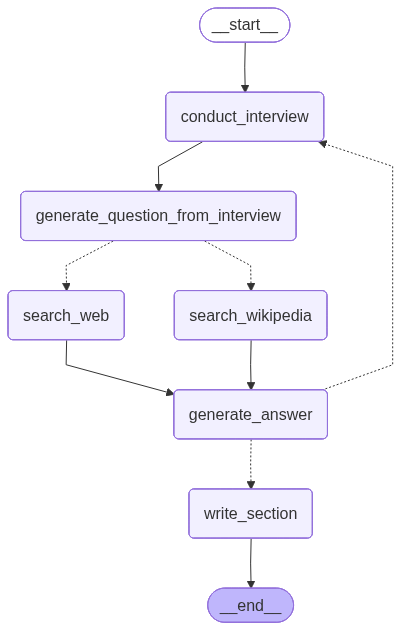

In [13]:
class InterviewState(BaseModel):
    topic: str
    analyst: Analyst
    conversations: Annotated[list[str], operator.add] = []
    questions: Annotated[list[str], operator.add] = None
    num_questions: int = 1
    search_results: Annotated[list[str], operator.add] = []
    answer: Annotated[list[str], operator.add] = []
    max_turns:int = 2
    section: str = None

class Questions(BaseModel):
    questions: list[str]
    
class SearchQueryState(BaseModel):
    query:str
  
interview_prmpt = """You are an analyst researching on the topic '{topic}'. You have a assigned role and organization. Here are the details about your persona and goals. {goals}.
 You are tasked with interviewing an expert to learn about the topic. 
 Follow these instructions while interviewing:
 1. Ask a specific and an insightful question about the topic. The question should be non-obvious that people will find exciting. 
 2. Avoid generalized or common questions.
 3. After receiving the expert answer, continue to ask further questions and drill down the expert to get a better understanding of the topic. 
 4. Once you are satisfied,complete the interview. 
 5. Throughout the interview stay in your character and persona and ask only those questions that aligns with your persona."""

generate_question_prmpt = """Below is the conversation between an analyst and an expert. 
Conversation: {conversation}
Your task is to refine the conversation into a set of {num_question} queries. These queries should be well-structured and be suitable for retrieving from wikipedia and / or web-search. Follow the below instructions.
 1. Analyse the full conversation.
 2. Pay particular attention to the question posed by the analyst.
 3. Convert the question posed by the analyst into a set of {num_question} web-search and arxiv retrieval queries.
 4. Break down composite questions into single-issue questions that are direct.
 5. Ask only one thing at a time suitable for web-search and wikipedia."""

generate_answer_prmpt = """You are an expert in the topic '{topic}'. Your task is to answer a set of  questions posed based on the given context. 
Questions: {questions}, Context: {context}. 
When answering the questions, follow these instructions.
1. Use only the provided context to answer the questions.
2. Do not introduce any other external information and do not make any assumptions other than those explicitly given in the context.
3. The context contains urls of the sources at the top of each document.
4. Include the sources in the answer next to any relevant statements. For example source 1 should be included as [1].
5.List your sources in order at the end of your answer. For example: [1] Source 1, [2] Source 2 etc.
6. If the source is: <Document href="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document href preamble in your citation."""

generate_section_prmpt = """You are an expert technical writer.
 You are given a topic and an area of focus within the topic.
 You are also given a set of questions and a set of relevant documents that answers the question.
Topic: {topic} , Area of focus: {focus}.
Your task is to create a section of the report from a set of source documents.
1. Create a report structure using the markdown formatting
- Use ## for the section title
- Use ### for sub-section headers.
2. Make you title engaging based on the question.
3. Each document has a title and a source given by href at the beginning.
4. For the summary section, 
- Start the summary with general background or context related to the question.
- Emphasize what is novel, interesting, or surprising about insights gathered from the documents
- Do not mention the names of the analysts or the experts
- Create a numbered list of source documents, as you use them
- Aim for approximately 300 words minimum and a maximum of 400 words.
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents.
5. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def conduct_interview(state: InterviewState):
    persona = f"Name: {state.analyst.name}, role: {state.analyst.role}, organization: {state.analyst.organization}, description: {state.analyst.description}"
    prmpt = interview_prmpt.format(goals=persona, topic=state.topic)
    # prmpt = question_prmpt.format(goals=persona)
    if len(state.conversations) != 0:
        human_message = HumanMessage(
            content = f"Here are the past interviews with the expert. Interview: {state.conversations}"
        )
        conversations = llm.invoke([SystemMessage(content=prmpt)] + [human_message])
    else:
        conversations = llm.invoke([SystemMessage(content=prmpt)])
    return {"conversations": [conversations.content]}
    
def generate_question_from_interview(state: InterviewState):
    prmpt = generate_question_prmpt.format(conversation=state.conversations, num_question=state.num_questions)
    response = llm.with_structured_output(Questions).invoke(prmpt)
    return {"questions": response.questions}

def fetch_answer_content(state: InterviewState):
    # return [Send("search_web", SearchQueryState(query=q)) for q in state.questions]
    web_results = [Send("search_web", SearchQueryState(query=q)) 
                   for q in state.questions[-state.num_questions:]]
    wikipedia_results = [Send("search_wikipedia", SearchQueryState(query=q)) 
                         for q in state.questions[-state.num_questions:]]
    return web_results + wikipedia_results
    
def search_web(state: SearchQueryState):
    exa = ExaSearchRetriever(
    apikey=EXA_API_KEY,
    k=2,
    summary=True, 
    text_contents_options={"max_characters": 3000}  
    )
    search_results = exa.invoke(state.query)
    combined_docs = "".join(
         f'<Document href="{doc.metadata["url"]}">\n'
         f'Question: {state.query}\n\n '
         f'Answer:\n Title: {doc.metadata["title"]}\n'
         f'Summary: {doc.metadata["summary"]}\n</Document>'
        for doc in search_results
    )
    return {"search_results": [combined_docs]}

def search_wikipedia(state: SearchQueryState):
    wikipedia_docs = WikipediaLoader(query=state.query, load_max_docs=2).load()
    formatted_search_docs = "".join(
        [
            f'<Document href="{doc.metadata["source"]}">\n'
            f'Question: {state.query}\n\n '
             f'Answer:\n Title: {doc.metadata["title"]}\n'
            f'Summary: {doc.metadata["summary"]}\n</Document>'
            for doc in wikipedia_docs
        ]
    )
    return {"search_results": [formatted_search_docs]}

def generate_answer(state: InterviewState):
    persona = f"Name: {state.analyst.name}, role: {state.analyst.role}, organization: {state.analyst.organization}, description: {state.analyst.description}"
    topic = state.topic
    context = state.search_results
    prmpt = generate_answer_prmpt.format(topic=topic, context=context, questions=state.questions)
    answer = llm.invoke([SystemMessage(content=prmpt)])
    answer.name = "expert"
    return {"answer": [answer.content]}
    
def route_messages(state: InterviewState):
    if len(state.answer) < 2:
        return "conduct_interview"
    else:
        return "write_section"

def write_section(state: InterviewState):
    prmpt = generate_section_prmpt.format(topic=state.topic, focus=state.analyst.description)
    human_message = HumanMessage(
        content = f"Use the below content to write the section in the report. Questions: {state.questions}"
                  f"Content : {state.search_results}"
    )
    response = llm.invoke([SystemMessage(content=prmpt), human_message])
    return {"section": [response.content]}   
    

interview_builder = StateGraph(InterviewState)
interview_builder = interview_builder.add_node("conduct_interview", conduct_interview)
interview_builder = interview_builder.add_node("generate_question_from_interview", generate_question_from_interview)
interview_builder = interview_builder.add_node("search_web", search_web)
interview_builder = interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder = interview_builder.add_node("generate_answer", generate_answer)
interview_builder = interview_builder.add_node("write_section", write_section)

interview_builder = interview_builder.add_edge(START, "conduct_interview")
interview_builder = interview_builder.add_edge("conduct_interview", "generate_question_from_interview")
interview_builder = interview_builder.add_conditional_edges("generate_question_from_interview", fetch_answer_content, ["search_web", "search_wikipedia"])
interview_builder = interview_builder.add_edge("search_web", "generate_answer")
interview_builder = interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder = interview_builder.add_conditional_edges("generate_answer", route_messages, ["conduct_interview","write_section"])
interview_builder = interview_builder.add_edge("write_section", END)
interview_graph = interview_builder.compile()
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [80]:
result = interview_graph.invoke(InterviewState(topic="Effect of AI on student learning", analyst=Analyst(name='Dr. Alex Carter', organization='Neuroscience Research Institute', role='Neurological Scientist', description='Dr. Alex Carter specializes in the study of how the brain processes information and learns. Her research focuses on the neural mechanisms underlying learning and memory, and she has a keen interest in how technology, including AI, impacts these processes.'), num_questions = 2))
result

{'topic': 'Effect of AI on student learning',
 'analyst': Analyst(name='Dr. Alex Carter', organization='Neuroscience Research Institute', role='Neurological Scientist', description='Dr. Alex Carter specializes in the study of how the brain processes information and learns. Her research focuses on the neural mechanisms underlying learning and memory, and she has a keen interest in how technology, including AI, impacts these processes.'),
 'conversations': ["**Dr. Alex Carter:** Hello! I'm Dr. Alex Carter from the Neuroscience Research Institute. I'm conducting research on the impact of AI on student learning, particularly from a neurological perspective. I'd love to interview you as an expert in this field. To start, I'm curious about something specific: *How does AI's ability to provide personalized, adaptive learning experiences influence the neural plasticity of students, and are there any long-term effects on their cognitive development?*\n\n**Expert:** Great question, Dr. Carter. A

In [83]:
result["conversations"]

["**Dr. Alex Carter:** Hello! I'm Dr. Alex Carter from the Neuroscience Research Institute. I'm conducting research on the impact of AI on student learning, particularly from a neurological perspective. I'd love to interview you as an expert in this field. To start, I'm curious about something specific: *How does AI's ability to provide personalized, adaptive learning experiences influence the neural plasticity of students, and are there any long-term effects on their cognitive development?*\n\n**Expert:** Great question, Dr. Carter. AI-driven personalized learning can indeed influence neural plasticity by tailoring content to a student's cognitive strengths and weaknesses. This adaptive approach can enhance engagement and optimize learning pathways, potentially leading to more efficient neural network formation. Long-term, it might foster more flexible cognitive strategies, but we need more research to understand the full extent of these effects.\n\n**Dr. Alex Carter:** That's fascina

In [75]:
len(result["search_results"])

8

In [47]:
result["search_results"]

[HumanMessage(content='<Document href="https://link.springer.com/article/10.1007/s10648-020-09570-w?error=cookies_not_supported&code=6aaee1a0-0910-42cd-adf7-206ba8702f63">\nQuestion: How does AI adapt to a student\'s learning style and pace, considering cognitive factors like working memory capacity or attention span?\n\n Answer:The article "Developing Personalized Education: A Dynamic Framework" discusses how personalized education can be effectively implemented by adapting instruction to individual learners\' characteristics, including cognitive factors such as working memory capacity and attention span. The authors propose a dynamic framework that emphasizes the importance of continuously measuring learner characteristics throughout the educational process. This allows for systematic adaptations in instruction, which can occur on different timescales—from setting overarching learning goals to responding to immediate affective and motivational changes.\n\nThe framework suggests that 

In [56]:
result["answer"]

[AIMessage(content='**Dr. Alex Carter:**\n"Thank you for taking the time to speak with me today. I\'m particularly interested in the neurological implications of AI-assisted learning. From your perspective, have you observed any unique patterns in brain activity when students engage with AI-driven educational tools compared to traditional learning methods? Specifically, are there any differences in the activation of the prefrontal cortex or the hippocampus, regions critical for executive function and memory consolidation, respectively?"\n\n**Expert Response:**\nYes, research has indeed identified unique patterns in brain activity when students engage with AI-driven educational tools compared to traditional learning methods. Studies have shown that AI chatbots providing personalized feedback can enhance self-regulated learning and motivation, potentially leading to different neural activation patterns. Specifically, these tools may activate regions associated with learning and memory, s

In [52]:
result["conversations"]

[AIMessage(content="**Dr. Alex Carter:** Thank you for taking the time to speak with me today. I'm particularly interested in understanding how AI is influencing student learning from a neurological perspective. To start, could you provide an overview of the most significant ways AI is currently being integrated into educational settings?\n\n**Expert:** Certainly, Dr. Carter. AI is being integrated into education in several ways, including personalized learning platforms, intelligent tutoring systems, and adaptive testing. These technologies use machine learning algorithms to tailor educational content to individual students' needs, learning styles, and pacing.\n\n**Dr. Alex Carter:** That's fascinating. From a neurological standpoint, personalized learning is intriguing because it aligns with the brain's plasticity and the concept of individualized learning pathways. Can you elaborate on how these AI systems adapt to a student's learning style and how that might impact neural processe

In [55]:
result["conversations"]

[AIMessage(content='**Dr. Alex Carter:**\n\n"Thank you for taking the time to speak with me today. I\'m particularly interested in the neurological implications of AI-assisted learning. From your perspective, have you observed any unique patterns in brain activity when students engage with AI-driven educational tools compared to traditional learning methods? Specifically, are there any differences in the activation of the prefrontal cortex or the hippocampus, regions critical for executive function and memory consolidation, respectively?"\n\n*(After receiving an answer, Dr. Carter might follow up with:)*\n\n"Fascinating. Could you elaborate on whether these neural differences are more pronounced in certain age groups or learning contexts? For instance, do younger students exhibit different brain activation patterns when interacting with AI tutors versus older students? Additionally, have you noticed any long-term effects on neural plasticity or cognitive flexibility as a result of prol

In [81]:
result["questions"]

["How does AI's ability to provide personalized, adaptive learning experiences influence the neural plasticity of students?",
 'What are the long-term effects of AI-driven personalized learning on cognitive development?',
 'How does AI-driven personalized learning influence neural plasticity and cognitive development in students?',
 "What are the effects of AI's immediate feedback on the dopamine and reward pathways in the brain, and could this lead to reduced intrinsic motivation or dependency on external validation?"]

In [82]:
result["section"]

["## AI and the Brain: Unlocking the Potential of Personalized Learning\n\n### Summary\n\nArtificial Intelligence (AI) is transforming education by providing personalized, adaptive learning experiences that align with neuroscience principles, particularly focusing on neural plasticity and cognitive development. The ability of AI to tailor educational experiences to individual learning styles and needs is crucial for promoting neural plasticity, as it allows for tailored educational experiences that cater to individual learning styles and needs, thereby fostering memory formation and cognitive development [1][2].\n\nAI-driven personalized learning systems, particularly those utilizing Large Language Models (LLMs), have shown potential in increasing student engagement, which is crucial for cognitive development. Engaged learners are more likely to retain information and develop critical thinking skills. Additionally, these systems facilitate continuous assessment and feedback, allowing f

In [74]:
result["search_results"]

[HumanMessage(content='<Document href="https://www.ceejournal.com/article_230111_bff1a8a842049547a4e50334db3ece87.pdf">\nQuestion: How does the adaptive nature of AI-driven educational tools influence the brain\'s neuroplasticity, particularly in terms of long-term memory consolidation?\n\n Answer:\n Title: \nSummary: The systematic review titled "The Impact of Artificial Intelligence on Learners’ Memory" explores how AI-driven educational tools affect memory processes, particularly in the context of long-term memory consolidation. The review synthesizes findings from 26 empirical studies across various educational levels, highlighting that AI interventions—such as large-language-model chatbots and adaptive feedback—often lead to improved immediate retention and benefits in delayed assessments (e.g., one week later or during exams).\n\nThe adaptive nature of these AI tools influences neuroplasticity by introducing structured learning experiences that enhance encoding and retrieval proc

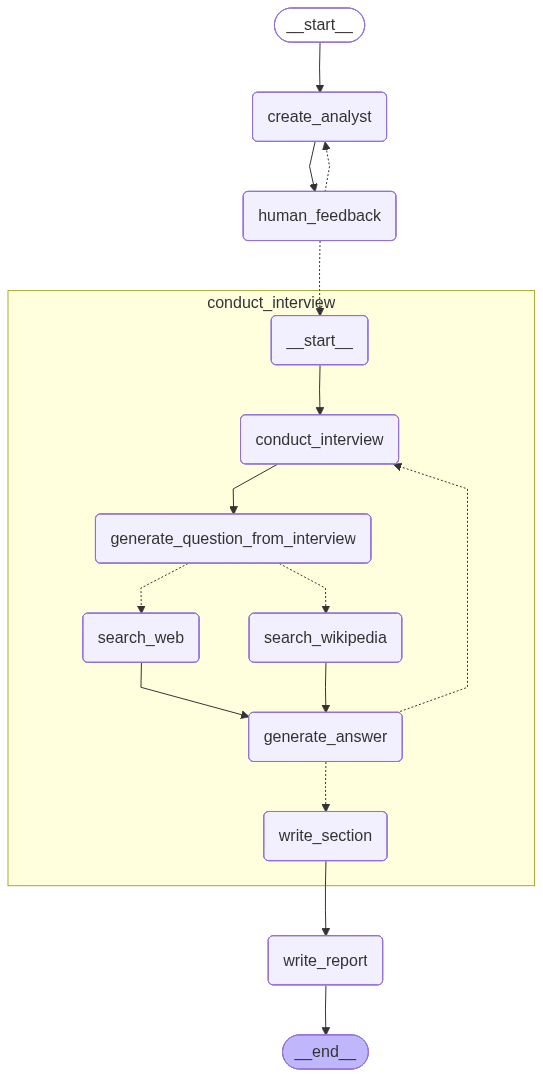

In [21]:
def operator_replace_string(left:str, right:str) -> str:
    if left is None or len(left) == 0:
        return right
    else:
        return left
    
def operator_replace_int(left:int, right:int) -> int:
    if left <= 0 < right:
        return right
    else:
        return left
    
write_report_prmpt = """You are an expert technical writer. You are given section about a topic written by {max_analysts} analysts.
Below is the topic and the sections written by analysts.
Topic: {topic}, Sections: {section}
Your task is to combine these sections into one coherent report. Follow the below instructions
1. Write a compelling introduction on why this report matters. 
2. Write a conclusion that summarizes the key points in the sections.
3. Each section has sources at the end. Combine these sources into one single source and add it to the end of the report.
4. Do not include any external information. Use only the information provided in the sections.
"""
  
class ResearchGraphState(BaseModel):
    max_analysts: int = 2
    topic: Annotated[str, operator_replace_string]
    human_feedback: Optional[str] = None
    analysts: list[Analyst] = []
    num_questions:Annotated[int, operator_replace_int] = 1
    section: Annotated[list[str], operator.add] = []
    report: str = None
    
    
def write_report(state: ResearchGraphState):
    prmpt = write_report_prmpt.format(max_analysts=state.max_analysts, topic = state.topic, section = state.section)
    response = llm.invoke([SystemMessage(content=prmpt)])
    return {"report": [response.content]}
    
def initiate_all_interviews(state: ResearchGraphState):
    print(f"Initiating interviews for {state.human_feedback}")
    if state.human_feedback is not None and state.human_feedback != "":
        print(f"create_analyst")
        return "create_analyst"
    else:
        print(f"Initiating interviews")
        return [Send("conduct_interview", InterviewState(topic=state.topic, num_questions=state.num_questions,
                                                         analyst=analyst)) for analyst in state.analysts]

research_graph_builder = StateGraph(ResearchGraphState)
research_graph_builder = research_graph_builder.add_node("create_analyst", create_analyst)
research_graph_builder = research_graph_builder.add_node("human_feedback", human_feedback)
research_graph_builder = research_graph_builder.add_node("conduct_interview", interview_builder.compile())
research_graph_builder = research_graph_builder.add_node("write_report", write_report)

research_graph_builder = research_graph_builder.add_edge(START, "create_analyst")
research_graph_builder = research_graph_builder.add_edge("create_analyst", "human_feedback")
research_graph_builder = research_graph_builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analyst", "conduct_interview"])
research_graph_builder = research_graph_builder.add_edge("conduct_interview", "write_report")
research_graph_builder = research_graph_builder.add_edge("write_report", END)
checkpointer = MemorySaver()
research_graph = research_graph_builder.compile(checkpointer=checkpointer)
display(Image(research_graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": 1}}
result = research_graph.invoke(ResearchGraphState(topic="AI in higher education"), config=config)
result

Initiating interviews for None
Initiating interviews


{'max_analysts': 2,
 'topic': 'AI in higher education',
 'analysts': [Analyst(name='Dr. Alice Chen', organization='AI Education Innovators', role='Senior AI Researcher', description='Dr. Alice Chen specializes in the integration of AI technologies into educational frameworks. Her work focuses on how AI can personalize learning experiences and improve educational outcomes in higher education.'),
  Analyst(name='Prof. Benjamin Thompson', organization='Future Learning Technologies', role='Professor of Educational Technology', description='Prof. Benjamin Thompson explores the ethical implications and practical applications of AI in higher education. He is particularly interested in how AI can enhance administrative efficiencies and support student success.')],
 'num_questions': 1,
 'section': ['## Harnessing AI to Predict and Address Learning Gaps in Higher Education\n\n### Summary\nThe integration of AI into higher education presents a transformative opportunity to predict and address lea

In [24]:
result.keys()

dict_keys(['max_analysts', 'topic', 'analysts', 'num_questions', 'section', 'report'])

In [25]:
result["analysts"]

[Analyst(name='Dr. Alice Chen', organization='AI Education Innovators', role='Senior AI Researcher', description='Dr. Alice Chen specializes in the integration of AI technologies into educational frameworks. Her work focuses on how AI can personalize learning experiences and improve educational outcomes in higher education.'),
 Analyst(name='Prof. Benjamin Thompson', organization='Future Learning Technologies', role='Professor of Educational Technology', description='Prof. Benjamin Thompson explores the ethical implications and practical applications of AI in higher education. He is particularly interested in how AI can enhance administrative efficiencies and support student success.')]

In [26]:
len(result["section"])

2

In [27]:
for section in result["section"]:
    print(section)
    print(f"{'='*50}")

## Harnessing AI to Predict and Address Learning Gaps in Higher Education

### Summary
The integration of AI into higher education presents a transformative opportunity to predict and address learning gaps before they become significant obstacles. This approach leverages data-driven insights to personalize learning experiences, ensuring that students receive timely interventions tailored to their needs. The novelty of this approach lies in its ability to combine adaptive learning technologies with human oversight, creating a synergistic relationship that enhances educational outcomes.

One of the most interesting aspects of AI in education is its capacity to identify patterns and trends that might otherwise go unnoticed. By analyzing student performance data, AI systems can predict potential learning gaps and suggest targeted interventions. This proactive approach not only improves student performance but also reduces the administrative burden on educators, allowing them to focus on mo

In [28]:
result["report"]

["# AI in Higher Education: Transforming Learning and Administration\n\n## Introduction\n\nThe integration of artificial intelligence (AI) into higher education is revolutionizing the way institutions operate, support students, and deliver education. As AI technologies advance, they offer unprecedented opportunities to enhance learning outcomes, streamline administrative processes, and promote equity and inclusion. This report explores the transformative potential of AI in higher education, focusing on its role in predicting and addressing learning gaps, personalizing administrative support, and ensuring ethical and equitable implementation. By leveraging AI, higher education institutions can create more responsive, efficient, and inclusive environments that better meet the diverse needs of students and faculty.\n\n## Harnessing AI to Predict and Address Learning Gaps\n\n### Summary\n\nThe integration of AI into higher education presents a transformative opportunity to predict and addr